## Method2:
- Train two separate models for "walk" and "trot", and then have each model make its own prediction. The final prediction will be the average of the predictions from the two models.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
import matplotlib.pyplot as plt
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [3]:
def preprocess(raw_data):
    
    raw_data.iloc[:,   9:189] = raw_data.iloc[:, 9:189].div(raw_data['weight'], axis=0) #normalize all the V colums to weight
    raw_data.iloc[:, 191:371] = raw_data.iloc[:, 191:371].div(raw_data['weight'], axis=0) #normalize all the V colums to weight

    raw_data['gait']=1 #change all string 'walk' to a number 1
    raw_data['Gait']=1 #change all string 'trot' to a number 1

    raw_data.loc[raw_data['speed'] .isin(['Not able to walk', 'no data','no valid trials', np.nan]), 'gait'] = 0 
    raw_data.loc[raw_data['speed'] .isin(['Not able to walk', 'no data','no valid trials', np.nan]), 'speed'] = np.nan

    raw_data.loc[raw_data['Speed'] .isin(['Not able to trot', 'no data','no valid trials', np.nan]), 'Gait'] = 0 
    raw_data.loc[raw_data['Speed'] .isin(['Not able to trot', 'no data','no valid trials', np.nan]), 'Speed'] = np.nan


    #drop object column, which is irrevelant colums to our modles
    raw_data.drop(['dob','forceplate_date'], axis=1, inplace=True)

    raw_data['speed'] = raw_data['speed'].astype(float)
    raw_data['Speed'] = raw_data['Speed'].astype(float)
    
    return raw_data

In [4]:
loca='LF'
raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
raw_data_val = pd.read_csv('raw_data/'+loca+'_val.csv')

data_train = preprocess(raw_data_train)
data_val = preprocess(raw_data_val)

## GridSearch: Trot Model 

In [5]:
def only_trot(data_train):
    drop_start_pos = data_train.columns.get_loc('gait')
    drop_end_pos = data_train.columns.get_loc('Gait')
    trot_train = data_train.drop(data_train.columns[drop_start_pos:drop_end_pos], axis=1)

    X_trot_train = trot_train.drop([loca, 'id'], axis=1)
    y_trot_train = trot_train[loca]
    return X_trot_train, y_trot_train

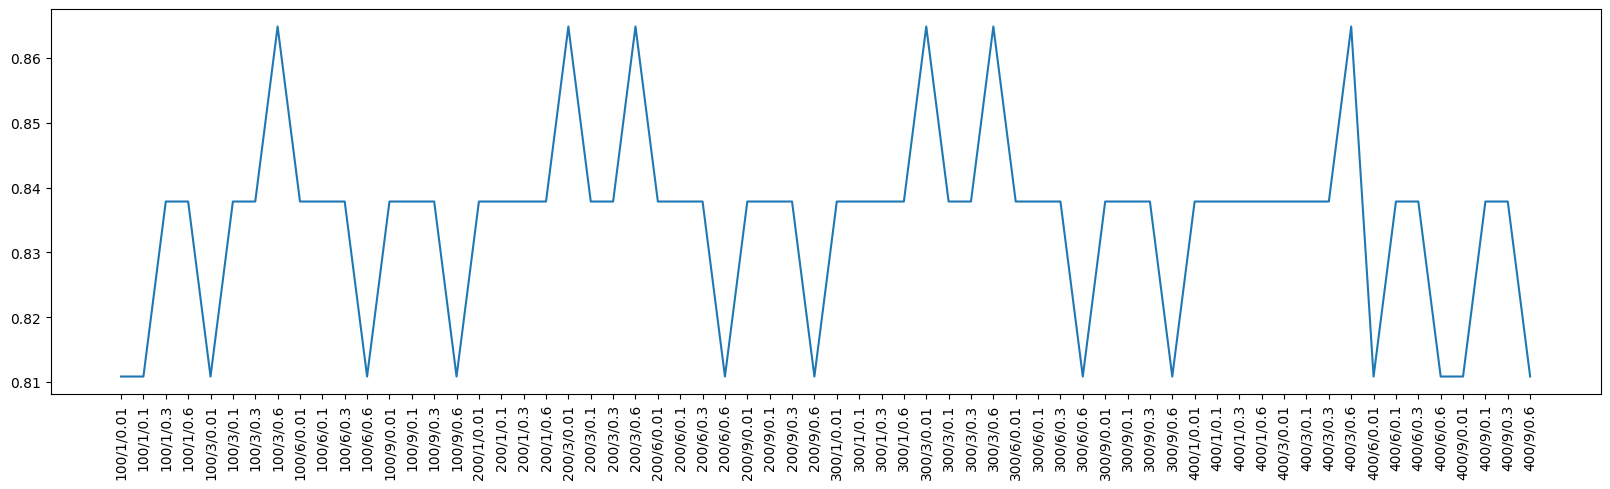

best_acc:0.8648648648648649
[400, 3, 0.6]


In [6]:
X_trot_train, y_trot_train = only_trot(data_train)
X_trot_val, y_trot_val = only_trot(data_val)


best_acc=0
best_param=[]
progress=0
pra_list=[]
acc_list=[]
for n_estimators in [100,200,300,400]:
    for max_depth in [1,3,6,9]:
        for learning_rate in [0.01, 0.1,0.3,0.6]:
            progress+=1
#             if progress%10==0:
#                 print(f'Progress:{progress}/{4*4*4}')
            xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators)
            xgb_clf.fit(X_trot_train, y_trot_train)
            y_trot_pred = xgb_clf.predict(X_trot_val)
            pra_list.append(f'{n_estimators}/{max_depth}/{learning_rate}')
            acc_list.append(accuracy_score(y_trot_val, y_trot_pred))
            if accuracy_score(y_trot_val, y_trot_pred)>= best_acc:
                best_acc=accuracy_score(y_trot_val, y_trot_pred)
                best_param=[n_estimators,max_depth,learning_rate]
                
plt.figure(figsize=(20, 5))
plt.plot(pra_list, acc_list)
plt.xticks(rotation='vertical')
plt.show()
print(f'best_acc:{best_acc}')
print(best_param)

##  GridSearch: Walk Model

In [7]:
def only_walk(data_train):
    drop_start_pos = data_train.columns.get_loc('Gait')
    walk_train = data_train.drop(data_train.columns[drop_start_pos:], axis=1)

    X_walk_train = walk_train.drop([loca, 'id'], axis=1)
    y_walk_train = walk_train[loca]
    
    return X_walk_train, y_walk_train

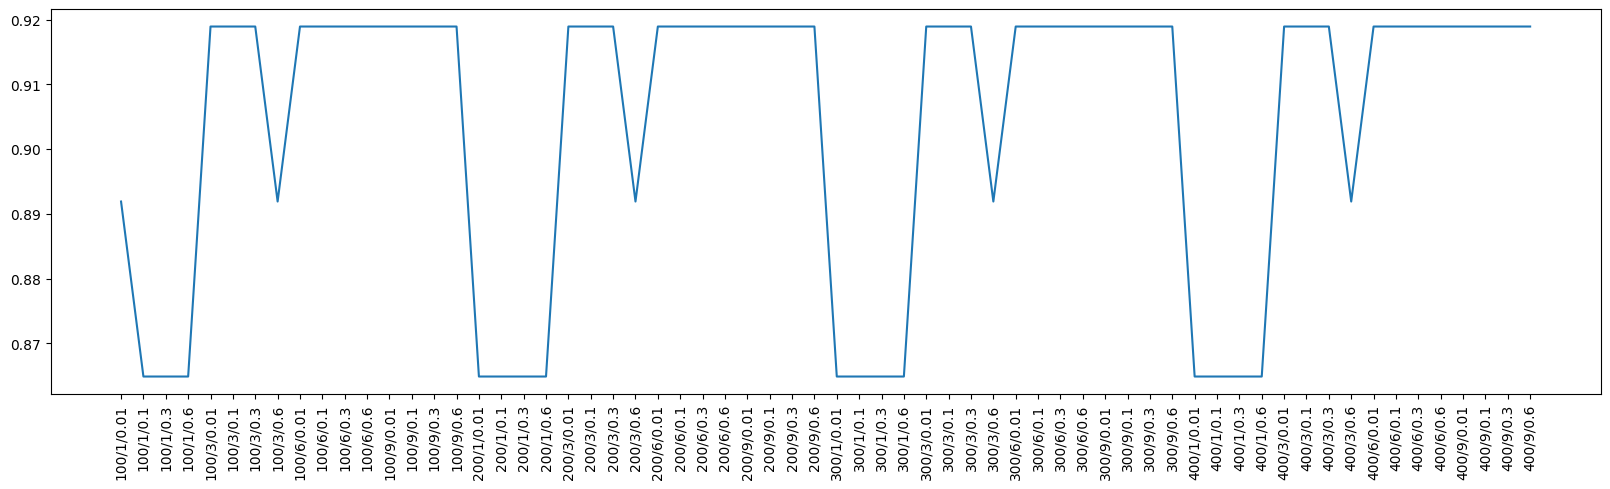

best_acc:0.918918918918919
[400, 9, 0.6]


In [8]:
X_walk_train, y_walk_train = only_walk(data_train)
X_walk_val, y_walk_val = only_walk(data_val)

best_acc=0
best_param=[]
progress=0
pra_list=[]
acc_list=[]
for n_estimators in [100,200,300,400]:
    for max_depth in [1,3,6,9]:
        for learning_rate in [0.01, 0.1,0.3,0.6]:
            progress+=1
#             if progress%10==0:
#                 print(f'Progress:{progress}/{4*4*4}')
            xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators)
            xgb_clf.fit(X_walk_train, y_walk_train)
            y_walk_pred = xgb_clf.predict(X_walk_val)
            pra_list.append(f'{n_estimators}/{max_depth}/{learning_rate}')
            acc_list.append(accuracy_score(y_walk_val, y_walk_pred))
            if accuracy_score(y_walk_val, y_walk_pred)>= best_acc:
                best_acc=accuracy_score(y_walk_val, y_walk_pred)
                best_param=[n_estimators,max_depth,learning_rate]
                
plt.figure(figsize=(20, 5))
plt.plot(pra_list, acc_list)
plt.xticks(rotation='vertical')
plt.show()
print(f'best_acc:{best_acc}')
print(best_param)

## Test

In [9]:
raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
raw_data_val = pd.read_csv('raw_data/'+loca+'_test.csv')

data_train = preprocess(raw_data_train)
data_val = preprocess(raw_data_val)

X_walk_train, y_train = only_walk(data_train)
X_trot_train, y_train = only_trot(data_train)

X_walk_val, y_val = only_walk(data_val)
X_trot_val, y_val = only_trot(data_val)

xgb_clf_walk = xgb.XGBClassifier(objective='binary:logistic', max_depth=3,learning_rate=0.01,n_estimators=100)
xgb_clf_walk.fit(X_walk_train, y_train)

xgb_clf_trot = xgb.XGBClassifier(objective='binary:logistic', max_depth=3,learning_rate=0.01,n_estimators=100)
xgb_clf_trot.fit(X_trot_train, y_train)

y_walk_pred = xgb_clf_walk.predict_proba(X_walk_val)[:, 1]
y_trot_pred = xgb_clf_trot.predict_proba(X_trot_val)[:, 1]
y_pred_prob = (y_walk_pred+y_trot_pred)/2
#     y_pred_prob = y_walk_pred
y_pred = np.where(y_pred_prob > 0.5, 1, 0)
#     print(y_pred)

acc = accuracy_score(y_val, y_pred)
print(f'acc for {loca} is:{acc}')


acc for LF is:0.8918918918918919
